In [2]:
%config Completer.use_jedi=False

In [3]:
import os
import requests
import csv
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

np.set_printoptions(suppress=True)

HOUSING_URL = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
HOUSING_PATH = os.path.join('housing_dataset')

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    response = requests.get(housing_url, stream=True)
    with open(os.path.join(housing_path, 'housing_data.csv'), 'w') as f:
        writer = csv.writer(f)
        for line in response.iter_lines():
            writer.writerow(line.decode('utf-8').split(','))
    response.close()
    
def load_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing_data.csv')
    return pd.read_csv(csv_path)

In [4]:
#fetch_housing_data()

In [5]:
# load the dataset
housing = load_data()
print(housing.shape)
housing.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Check the basic info about the data.

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We see that there are some values missing in total_bedrooms feature. We will take care of it later. We can simply drop the values or try to impute them, there are also other options using random forest or KNN.

Get basic statistics about the data.

In [7]:
housing.describe().T.join(housing.skew(numeric_only=True).to_frame(name='skew')).round(2)

,count,mean,std,min,25%,50%,75%,max,skew
longitude,20640.0,-119.57,2.00,-124.35,-121.80,-118.49,-118.01,-114.31,-0.30
latitude,20640.0,35.63,2.14,32.54,33.93,34.26,37.71,41.95,0.47
housing_median_age,20640.0,28.64,12.59,1.00,18.00,29.00,37.00,52.00,0.06
total_rooms,20640.0,2635.76,2181.62,2.00,1447.75,2127.00,3148.00,39320.00,4.15
total_bedrooms,20433.0,537.87,421.39,1.00,296.00,435.00,647.00,6445.00,3.46
population,20640.0,1425.48,1132.46,3.00,787.00,1166.00,1725.00,35682.00,4.94
households,20640.0,499.54,382.33,1.00,280.00,409.00,605.00,6082.00,3.41
median_income,20640.0,3.87,1.90,0.50,2.56,3.53,4.74,15.00,1.65
median_house_value,20640.0,206855.82,115395.62,14999.00,119600.00,179700.00,264725.00,500001.00,0.98


Seems like there is a lot skewness in the data, we can get a better look plotting the histograms.

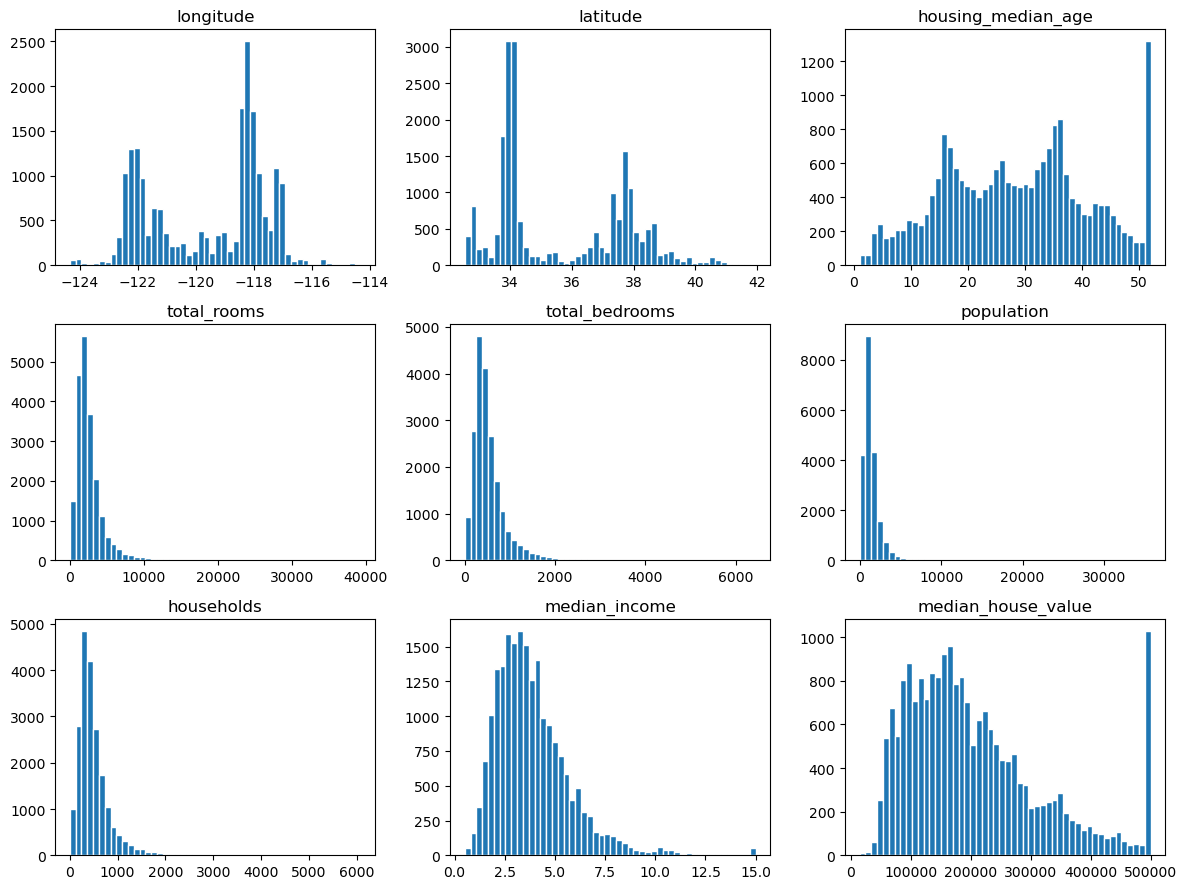

In [8]:
housing.hist(bins=50, ec='white', grid=False, figsize=(12, 9))
plt.tight_layout()
plt.show()

1. We can see that both housing_median_age and median_house_value are capped at their max values, meaning that max values of this feature and target variables contain all the data that was >= than their max values. We also observe similar spike in right-tail in median_income. 
2. Also, median_income does look like it is in 10,000$.
3. All the features have different scales so we should scale them, and a lot of them are heavy-tailed to the right. We can try to apply some transformation later down the road.

We should decide on what to do with capped target variable, as the model we will build could never learn that prices can go beyond the cap, and also the differences in other features will not result in the difference in the target variable which can bias the model. We can see from the histogram that there should be around 1000 examples in the dataset, which is around 5% of the data, we can check to be sure, and if this is the case then we will drop those values.

In [9]:
housing['median_house_value'].value_counts(normalize=True).head()

500001.0    0.046754
137500.0    0.005911
162500.0    0.005669
112500.0    0.004990
187500.0    0.004506
Name: median_house_value, dtype: float64

Capped values contribute less than 5% to the dataset, so we are dropping them. We will do so by creating a function, that we can then put into a pipeline, and check at the end if retrieving 500k will make any difference.

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

col_idx_dict = {housing.columns[i]:i for i in range(housing.shape[1])}

class CappedTargetDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_max_val=True):
        self.drop = drop_max_val
    def fit(self, X):
        max_val = X[:, col_idx_dict['median_house_value']].max()
        idx_to_drop = X[:, col_idx_dict['median_house_value']] != max_val
        self.idx_to_drop = idx_to_drop
        return self
    def transform(self, X):
        if self.drop:
            return X[self.idx_to_drop, :]

# drop the values
housing_w_o_500k = pd.DataFrame(CappedTargetDropper().fit_transform(housing.values), columns=col_idx_dict.keys())

In [11]:
housing_w_o_500k = housing.loc[housing['median_house_value'] != housing['median_house_value'].max(), :]

We can now split the data into train (80%) and test (20%).

In [12]:
# split the data, we shuffle the data to be sure that the split is not biased
train, test = train_test_split(housing_w_o_500k, test_size=0.2, shuffle=True, random_state=42)
print(f'''train: {train.shape}, test: {test.shape}''')

train: (15740, 10), test: (3935, 10)


We can now copy the training set making sure not to mess something up and start exploring.

In [13]:
# copy the training set
tr = train.copy()

Since we have a longitude and latitude we can plot the region of our data, we can size the points with population and apply color mapping with median_house_value, for better visualization.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

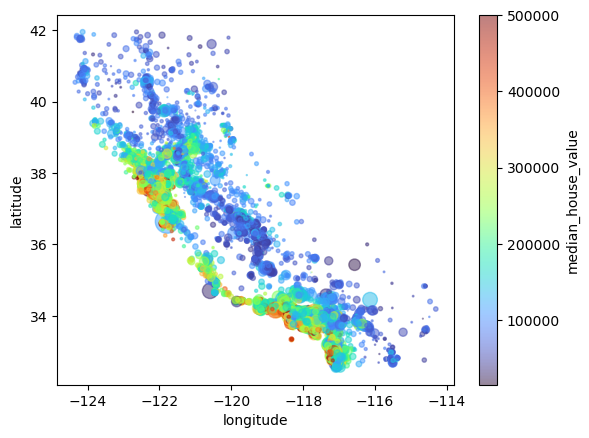

In [14]:
tr.plot(kind='scatter', x='longitude', y='latitude', s=tr['population'] / 100, c='median_house_value', colorbar=True, cmap='turbo', alpha=0.5)

We can clearly see that the closer to the coast we are the higher the median house values, but in Northern California the housing prices are nott too high.

We can take a look at correlations between features and the target variable. But first let's separate numerical features from ocean_proximity.

In [15]:
# separate features
tr_num, tr_cat = tr.drop(columns=['ocean_proximity']), tr.loc[:, 'ocean_proximity']

We should take care of nan values.

In [16]:
tr_num.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        162
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

There are 162 (~1%) missing values in the total_bedrooms feature, we can thing of bunch of methods to fix it, but we will impute with median value, which is the easiest one.

In [17]:
tr_num.loc[:, 'total_bedrooms'] = SimpleImputer(strategy='median').fit_transform(tr_num['total_bedrooms'].values.reshape(-1, 1))

Later, when we will be constructing the preprocessing pipeline, we will impute on the whole dataset, and store the median value for each feature, to be able to impute if we ever get any nan values in the future data.

In [18]:
corr_matrix = tr_num.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.641169
total_rooms           0.142128
households            0.094177
total_bedrooms        0.072501
housing_median_age    0.070008
population            0.013116
longitude            -0.044771
latitude             -0.151021
Name: median_house_value, dtype: float64

1. We can clearly see that the median_income feature is highly correlated with the target variable. 
2. We see that total_rooms is somehow correlated with target feature, as the number of rooms will definitely affect the overall total area of the house, and the bigger the house, we can assume the higher the price.
3. households and total_bedrooms are mildly correlated with the target variable.

Each observation in the data describes some region in California. Some features are not very informative, for example, total_rooms is not informative and is conterintuitive, its like trying to guess the median house value based on total rooms in the city. We can create new features that should be more informative, but for sure ones that will be intuitive, like for example total rooms per household, or median income per household. Then, we can check how much correlated those features have with the target variable. 

Note: income per household or per population is a little bit trickier, as we have median income per district, so we should think what exactly does it mean. Mean is close to the median most of the times, we assume that for the sake of argument. So if we were dealing with mean income per district how would it be calculated? We would take all the people that earns money sum them up and then divide by the number of people, and we would do it in every district, so it would be mean income per people that earns money. So given our data we can have two cases, all the population in the district earns money or one person per household. If the former is true then we calculate median income per household by median_income * population / households, if the latter is true then we can calculate median income per population by median_income * households / population.

In [19]:
# create new features
tr_num.loc[:, 'rooms_per_household'] = tr_num['total_rooms'] / tr_num['households']
tr_num.loc[:, 'income_per_household'] = tr_num['median_income'] / tr_num['households'] * tr_num['population']
tr_num.loc[:, 'income_per_population'] = tr_num['median_income'] / tr_num['population'] * tr_num['households']
tr_num.loc[:, 'bedrooms_per_rooms'] = tr_num['total_bedrooms'] / tr_num['total_rooms']
tr_num.loc[:, 'population_per_household'] = tr_num['population'] / tr_num['households']
tr_num.loc[:, 'rooms_per_age'] = tr_num['total_rooms'] / tr_num['housing_median_age']

Adding features should be encapsulated into a sklearn estimator.

In [54]:
col_idx_dict = {housing.columns[i]:i for i in range(housing.shape[1])}

class AddFeatures(BaseEstimator, TransformerMixin):
    '''
    Adds new features to the dataset.
    
    Args:
        X (np.ndarray): (m, n) Data points
        
    Returns:
        X (np.ndarray): (m, n + 6) Dataset with added features
    '''
    def fit(self, X):
        
        # return self
        return self
    
    def transform(self, X):
        
        # create arrays of new features
        rooms_per_household      = X[:, col_idx_dict['total_rooms']]    / X[:, col_idx_dict['households']]
        income_per_household     = X[:, col_idx_dict['median_income']]  / X[:, col_idx_dict['households']] * X[:, col_idx_dict['population']]
        income_per_population    = X[:, col_idx_dict['median_income']]  / X[:, col_idx_dict['population']] * X[:, col_idx_dict['households']]
        bedrooms_per_rooms       = X[:, col_idx_dict['total_bedrooms']] / X[:, col_idx_dict['total_rooms']]
        population_per_household = X[:, col_idx_dict['population']]     / X[:, col_idx_dict['households']]
        rooms_per_age            = X[:, col_idx_dict['total_rooms']]    / X[:, col_idx_dict['housing_median_age']]
        
        # return concatenated dataset
        return np.c_[X, rooms_per_household, income_per_household, income_per_population, bedrooms_per_rooms, population_per_household, rooms_per_age]

In [21]:
corr_matrix_new_features = tr_num.corr()
corr_matrix_new_features['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
income_per_population       0.692206
median_income               0.641169
total_rooms                 0.142128
rooms_per_household         0.104761
households                  0.094177
total_bedrooms              0.072501
housing_median_age          0.070008
rooms_per_age               0.045724
income_per_household        0.016828
population                  0.013116
population_per_household   -0.019670
longitude                  -0.044771
latitude                   -0.151021
bedrooms_per_rooms         -0.193912
Name: median_house_value, dtype: float64

Nice, we have created features that in some cases are more informative than some of its components. For example rooms_per_household is a little more correlated than households alone, income_per_population is more correlated than median_income itself, the most linearly correlated feature in our data, and bedrooms_per_rooms is highly negatively correlated in comparasion to the total_rooms and total_bedrooms, so it turns out that the lower the ration bedrooms/rooms the higher the price tend to be. We have to keep in mind that pearson measures the linear correlation, so it will not capture non-linear ones, we could try different method, like kendall, or spearman, but this can be done later. Also, income_per_household has almost 0 correlation with median_house_value, but if we take a log(income_per_household) then the correlation is around 0.4. This might be the case for more features and so this further suggest using some kind of transformation, for example Box-Cox.

Now we can check the correlation between features, so we can spot the relation between them.

<Figure size 1000x800 with 0 Axes>

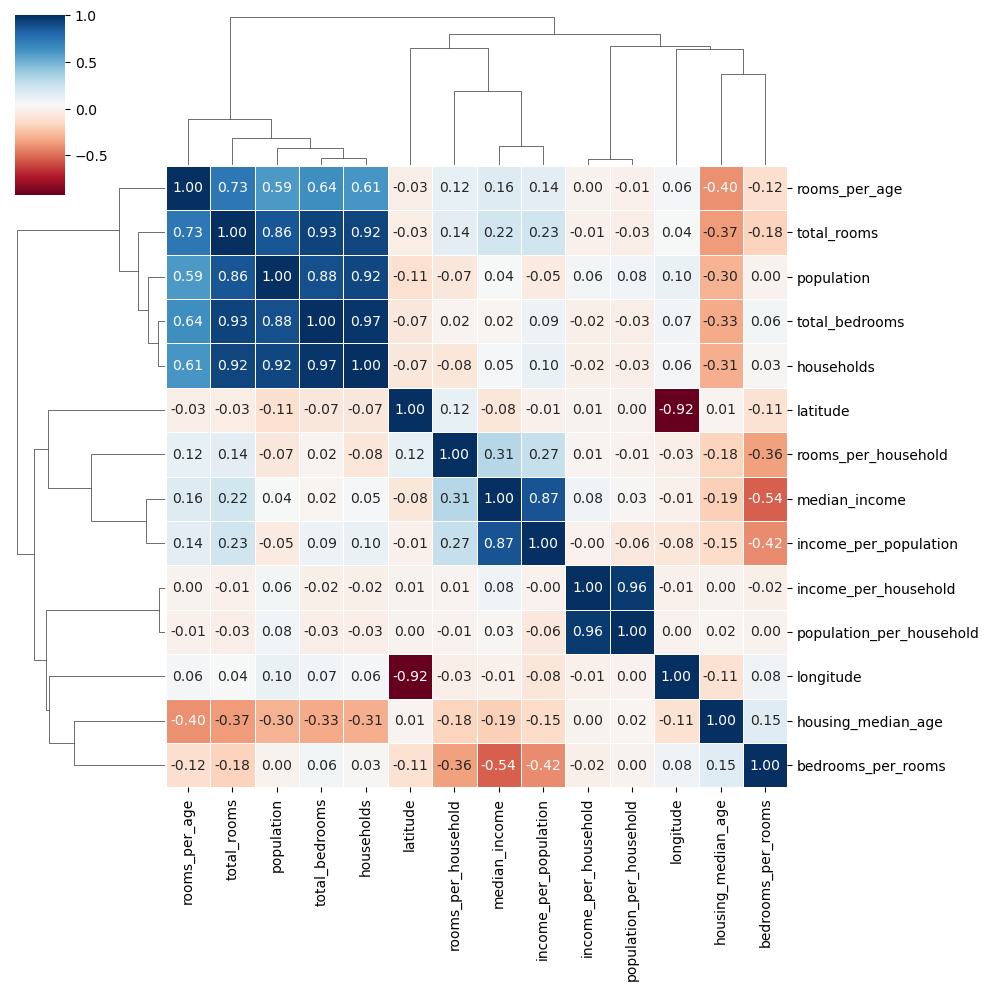

In [22]:
plt.figure(figsize=(10, 8))
sns.clustermap(corr_matrix_new_features.drop(index=['median_house_value'], columns=['median_house_value']), 
               annot=True, fmt='.2f', cmap='RdBu', lw=0.5);

We can see that we have two main clusers of highly correlated features. \
The first one in the upper left corner is mainly related to population in the district, so the more people the more households, the more households the more rooms and the more rooms the more bedrooms. \
The second cluster tells us that income_pre_pop is highly correlated with median_income, but this is not the case for income_per_household, which is correlated only with population_per_household. This is interesting because both those features are only correlated with each other and has almost 0 correlation with other features, it can suggest that those features are highly skewed, or has some bad ouliers. \
housing_median_age is negatively correlated with almost any feature, and the same goes for the ratio of bedrooms per rooms in the household, what is really interesting is that this ratio has high negative correlation with median_income, the ratio tends to be lower but this is because the overall number of rooms tend to goes up with almost constant bedrooms.

Keeping all the highly correlated features can result in multicollinearity, which can result in obtaining an unstable model if we would decide to use linear regression models, as it can cause linear dependency among columns of our data. Intuitively  if we increase population, the number of households will raise since those additional people must have a place to live in, and so the total number of rooms also will raise, so intuitively we have multicollinearity problem. So what we can do about it? There are multiple ways of handling this, we can: 


1. Just drop N-1 highly correlated variables for each "group" we have spotted and keep only the one that has the highest correlation with taget variable. This, of course will result in some lose in information, and can produce so-called omitted-variable bias among the rest of features when proceeding with linear models.
2. We can use PCA among spoted high correlation groups, but there is a publication (Jolliffe, Ian T. (1982). "A note on the Use of Principal Components in Regression") which shows that principal components with low eigenvalues can sometimes be more important than the principal components with high eigenvalues. This means that we can project important features on the subspace with basis for less important features.
3. We can treat the highly correlated group as just a group, because at the group level, multicollinearity is not a problem (Tsao, Min (2022). "Group least squares regression for linear models with strongly correlated predictor variables".). This amounts to finding some new feature that captures the effect of the group. This is done as $X_{new} = X_{old} \mathsf{w}$, where $||\mathsf{w}||_{1} = 1$, so $\mathsf{w}$ is as vector of weights.
4. Leave the model as is, despite multicollinearity. The presence of multicollinearity doesn't affect the efficiency of extrapolating the fitted model to new data, provided that the predictor variables follow the same pattern of multicollinearity in the new data as in the data on which the regression model is based. ( Gujarati, Damodar (2009). "Multicollinearity: what happens if the regressors are correlated?") We would expect that if we gather new data the first group would be still correlated, but we can think of exceptions, for example in some district new houses are build so households is increasing the number of rooms too, but there might be some economical reasons that people are not flowing the region, so we are losing the assumption that the multicollinearity will be the same.

There are few options left like using l2-norm regularization, partial LSR or obtaining more data. We will try to implement all the above options even if we will not use linear model, because one of those methods can still yield better model as three of four methods described above are about reducing the dimentionality.

Now we can check on pairplot how the groups are distributed and what their plots against each other looks like, we may be able to spot what is going on. Since i like hexbin plot this is the one i will use.

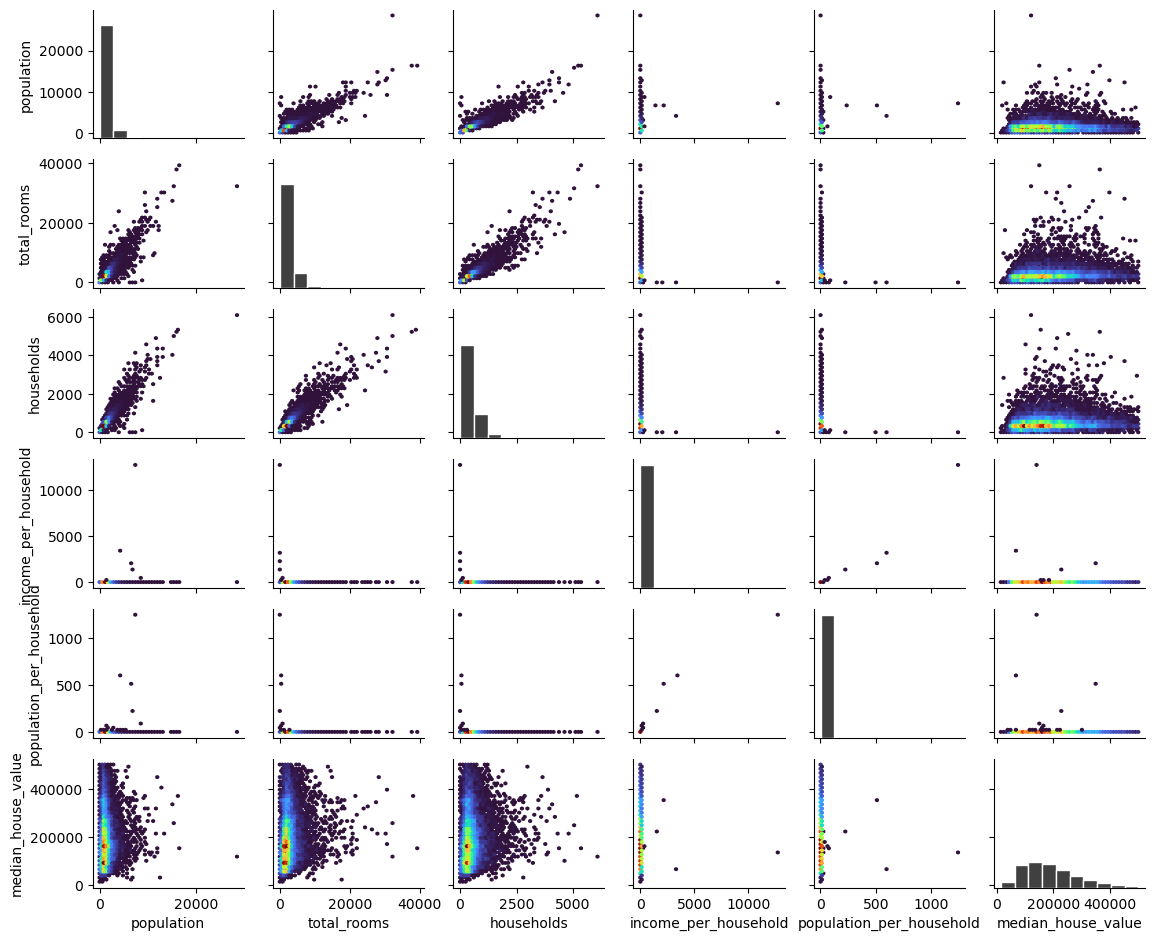

In [55]:
def _hexbin(x, y, color, **kwargs):
    
    # creates hexbin plot
    plt.hexbin(x, y, gridsize=50, cmap=color, mincnt=1, **kwargs)
    
g = sns.PairGrid(tr_num[['population', 'total_rooms', 'households', 'income_per_household', 'population_per_household', 'median_house_value']], 
                 height=1.6, aspect=1.2)
g.map_diag(sns.histplot, color='black', ec='white', bins=10)
g.map_offdiag(_hexbin, color='turbo')

We can see why income_per_household and population_per_household were only correlated with each other and had 0 correlation with other features, they are completely squeezed because of what looks like few outliers. We can identify those points manually.

In [56]:
outlier_check = tr_num.loc[tr_num['population_per_household'].sort_values(ascending=False).index[:14], :].T
outlier_check.style.apply(lambda x: 
                          ['background: #FFAE9B' if (x.name == 'population_per_household' or x.name == 'income_per_household') else '' for i in x],
                          axis=1)

,19006,3364,16669,13034,9172,12104,16420,13366,5986,20352,14756,4479,19435,16672
longitude,-121.980000,-120.510000,-120.700000,-121.150000,-118.590000,-117.330000,-121.290000,-117.630000,-117.710000,-119.090000,-116.970000,-118.160000,-121.040000,-120.690000
latitude,38.320000,40.410000,35.320000,38.690000,34.470000,33.970000,37.890000,33.940000,34.100000,34.220000,32.560000,34.070000,37.670000,35.340000
housing_median_age,45.000000,36.000000,46.000000,52.000000,5.000000,8.000000,26.000000,36.000000,52.000000,8.000000,23.000000,41.000000,16.000000,16.000000
total_rooms,19.000000,36.000000,118.000000,240.000000,538.000000,152.000000,161.000000,447.000000,567.000000,40.000000,1262.000000,247.000000,19.000000,164.000000
total_bedrooms,5.000000,8.000000,17.000000,44.000000,98.000000,19.000000,27.000000,95.000000,152.000000,10.000000,294.000000,55.000000,19.000000,30.000000
population,7460.000000,4198.000000,6532.000000,6675.000000,8733.000000,1275.000000,1542.000000,2886.000000,2688.000000,309.000000,5176.000000,925.000000,166.000000,542.000000
households,6.000000,7.000000,13.000000,29.000000,105.000000,20.000000,30.000000,85.000000,126.000000,16.000000,275.000000,50.000000,9.000000,32.000000
median_income,10.226400,5.517900,4.263900,6.135900,4.239100,1.625000,5.748500,4.257800,1.875000,4.020800,2.562500,3.576900,0.536000,1.656300
median_house_value,137500.000000,67500.000000,350000.000000,225000.000000,154600.000000,162500.000000,162500.000000,183300.000000,212500.000000,52500.000000,153300.000000,135700.000000,162500.000000,42500.000000
rooms_per_household,3.166667,5.142857,9.076923,8.275862,5.123810,7.600000,5.366667,5.258824,4.500000,2.500000,4.589091,4.940000,2.111111,5.125000


So, what seems to be the problem here? For the first observation of index no. 19006 we can see that the population is 7460, but the region has only 6 households, this seems weird. We can try to argue that it might be the case that those are big hotels classified as households, but quick look at total_rooms reveals 19 rooms, so no matter how much we try to wiggle our explanation it seems like this is just an error. The same goes for the rest of at least few more data points. Of course, it might be the case that some some apartaments or housing complexes vere classified as households, we don't know the exact way of classification, as this information is not provided, but we can check what are percentiles of those features, then we will know how much they are off. 

In [25]:
tr_num[['population_per_household', 'income_per_household']].describe(percentiles=[0.95, 0.99, 0.999, 0.9995]).T

,count,mean,std,min,50%,95%,99%,99.9%,99.95%,max
population_per_household,15740.0,3.131052,11.878814,0.692308,2.837905,4.342409,5.402575,14.191854,22.980192,1243.333333
income_per_household,15740.0,12.052259,106.772775,0.402000,9.732974,20.569154,26.818906,49.756627,81.037138,12714.824000


99.95% of data points have less or equal value than 22.98 in population_per_household, we can tell that the points with value greater than that are more than extreme outliers. There is no reason to keep them, so we should write a function that will drop those samples and be a part of data preprocessing pipeline. If we wouldn't have create that features we would never guess that there are such errors in the data. We can drop the points in two ways, we can either use a fixed value as a reference or use 99.9 percentile (or even lower) as a more flexible reference. We can add those two options to our function. There is also a question based on which feature we should proceed with droping the data? I would argue that we should be dropping based on more skewed feature.

We should also take into consideration that we are going to lose some data, so how much we should be willing to lose? Let's drop all above 99 percentile and see how much data we are dropping.

In [26]:
tr_num.shape[0], tr_num.loc[tr_num['population_per_household'] <= 5.41].shape, tr_num.loc[tr_num['income_per_household'] < 26.82].shape

(15740, (15583, 15), (15582, 15))

So dropping on 99 percentile will get rid of 157 data points, not too much. We can also try to tackle this solution as an optimization problem. Let's calculate skewness of those features and i will explain.

In [27]:
tr_num[['population_per_household', 'income_per_household']].skew()

population_per_household     85.564217
income_per_household        109.524705
dtype: float64

We should be punished for high skewness but also for dropping the data so let's construct simple loss funciton: $S(i) + i$, where $S(i)$ is the skewness after dropping ith point. The more points we get rid of the lower the skewness but ultimatelly we are dropping the data, so we want to find the maximum points we should drop to lower skewness as much as possible with as little points dropped. Also, if skewness ~ 1 the distribution can be treated almost as normal, so this can be another method of dropping those points.

All those ideas can be implemented in a class that will drop those points. We should specify the method of dropping, for example: fixed - with some constant based on percentiles from training set, flexible - dropping on percentiles of actually held data, optimized - based on skewness, or skew - for dropping after $S(i) \approx some\ constant$.

In [58]:
len('This class drops points considered outliers given the feature and method of dropping them.')

90

In [59]:
col_idx_dict = {tr_num.columns[i]:i for i in range(tr_num.shape[1])}

from scipy.stats import skew, iqr

class DataDropper(BaseEstimator, TransformerMixin):
    '''
    This class drops points considered outliers given the feature and method of dropping them. 
    Available methods are:
    "fixed"     - drops data that are <= choosen fixed threshold,
    "flexible"  - drops data that are <= choosen quantile,
    "optimized" - drops data with the help of a simple loss function:
                  $L(i, p) = S(i) + i^{p}$
                  where, i is the ith dropped data point, S(i) is the skewness after dropping
                  the ith data point and p is the penalty. The main assumption is that with
                  highly skewed features dropping points will monotonically lower the skewness.
                  Adding a penalty of $i^{p}$ creates a global minimum, that we seek to find,
    "skewness"  - drops data untill some fixed value of skewness is satisfied.
    
    Args:
        method (str)                     - method to use when dropping the data
        feature (str)                    - feature variable to drop data from
        val (float | int)                - value for "fixed", "flexible", and "skewness" methods.
                                           For "fixed" the value must be some point in the interval of given
                                           feature. For "flexible" method the value must be a quantile [0, 1] 
                                           which will specify the threshold for dropping points. For "skewness"
                                           the value must be a minimal skewness we want to obtain, it must be
                                           lower than the skewness of the feature itself.
        penalty (str, default "sq_root") - specifies what penalty is added to the loss after dropping ith point.
                                           If "linear" we take i to the 1th power. If "sq_root" i is raised to
                                           the power of 0.5.
    '''
    
    def __init__(self, method, feature, penalty="sq_root", val=None):
        assert(method in ['fixed', 'flexible', 'optimized', 'skewness']), 'methods available: "fixed", "flexible", "optimized", "skewness".'
        assert(feature in col_idx_dict.keys()), f'feature must be one of : {list(col_idx_dict.keys())}'
        self.method = method
        self.val = val
        self.feature = feature
        self.col_index = col_idx_dict[self.feature]
        self.penalty = penalty
        
    def check_val(self, val):
        assert((type(val) == float) or (type(val) == int)), f'specify the value (int, float) for right parameter of {self.method} method.'
        
    def flag_outliers(self, X):
        _iqr = iqr(X[:, self.col_index])
        _lower_bound = np.quantile(X[:, self.col_index], 0.25) - 1.5 * _iqr
        _upper_bound = np.quantile(X[:, self.col_index], 0.75) + 1.5 * _iqr
        return X[(X[:, self.col_index] <= _lower_bound) | (X[:, self.col_index] >= _upper_bound), self.col_index]
    
    def fit(self, X):
        if self.method == 'fixed':
            # make sure that fix value is specified
            self.check_val(self.val)
            # make sure that the point is in the interval of data
            _max_val = X[:, self.col_index].max()
            _min_val = X[:, self.col_index].min()
            assert((self.val <= _max_val) and (self.val >= _min_val)), 'the value must be in interval [min, max].'
            self.idx_to_keep = X[:, self.col_index] <= self.val
            
        if self.method == 'flexible':
            # make sure that flex value is specified
            self.check_val(self.val)
            # make sure that the quantile is in [0, 1]
            assert((self.val <= 1) and (self.val >= 0)), 'the value must be in interval [0, 1].'
            self.idx_to_keep = X[:, self.col_index] <= np.quantile(X[:, self.col_index], self.val)
            
        if self.method == 'optimized':
            
            assert(self.penalty in ['linear', 'sq_root']), 'penalties available: "linear", "sq_root".'
            if self.penalty == 'linear':
                self.penalty = 1
            else:
                self.penalty = 0.5
            
            loss = np.zeros(1)
            skewness_of_data = skew(X[:, self.col_index])
            sorted_data = np.sort(self.flag_outliers(X))[::-1]
            for point, data in enumerate(sorted_data):
                if point < skewness_of_data:
                    loss = np.c_[loss, skew(X[X[:, self.col_index] <= data, self.col_index]) + point ** self.penalty]
                else:
                    break
            loss = loss[loss > 0].flatten()
            self.optimization_history = loss
            self.idx_to_keep = X[:, self.col_index] <= sorted_data[loss.argmin()]
            
        if self.method == 'skewness':
            # make sure that skew value is specified
            self.check_val(self.val)
            # make sure that the skew value is lower than max skewness observed
            max_skew = skew(X[:, self.col_index])
            assert(self.val <= max_skew), f'Value for skewness is higher than the maximum skewness observed in the data: {self.val} > {round(max_skew, 1)}.'
            sorted_data = np.sort(X[:, self.col_index])[::-1]
            for point, data in enumerate(sorted_data):
                skew_after_drop = skew(X[X[:, self.col_index] <= data, self.col_index])
                if skew_after_drop <= self.val:
                    self.idx_to_keep = X[:, self.col_index] <= data
                    break
        
        self.number_deleted = X.shape[0] - self.idx_to_keep.sum()
        return self
        
    def transform(self, X):
        return X[self.idx_to_keep, :]

Let's drop the values using optimized method with square root penalty.

In [29]:
outliers_dropper = DataDropper(method='optimized', feature='income_per_household', penalty='sq_root')
outliers_dropper.fit(tr_num.values)
tr_num_outliers_dropped = pd.DataFrame(outliers_dropper.transform(tr_num.values), columns=col_idx_dict)
print(f'Dropped points: {outliers_dropper.number_deleted}')
tr_num_outliers_dropped.skew()

Dropped points: 8


longitude                   -0.284396
latitude                     0.448910
housing_median_age           0.068227
total_rooms                  4.352189
total_bedrooms               3.518783
population                   4.066135
households                   3.421765
median_income                0.917665
median_house_value           0.805984
rooms_per_household         17.579151
income_per_household         1.558933
income_per_population        0.830054
bedrooms_per_rooms           7.477090
population_per_household     4.537374
rooms_per_age               13.176987
dtype: float64

We were able to reduce skewness of income_per_household from 109 to 1.55 and population_per_household from 85 to 4.5, by just dropping 8 data points using squared root penalty (we can of course try to use different penalties)!

We can now also spot that rooms_per_household and rooms_per_age are badly skewed, not as much as two features we have just fixed and showed that the skewness in those features was because of erroneous data points. We should check if rooms_per_household and rooms_per_age also have some errors in them or the skewness comes from outliers (it might be also the case that those "outliers" are not outliers at all, but we don't have the population distribution which is called a statistical uncertainty).

In [30]:
outlier_check = tr_num_outliers_dropped.loc[tr_num_outliers_dropped['rooms_per_household'].sort_values(ascending=False).index[:14], ['total_rooms', 'households', 'housing_median_age', 'rooms_per_household', 'rooms_per_age']].T
outlier_check.style.apply(lambda x: 
                          ['background: #FFAE9B' if (x.name == 'rooms_per_household' or x.name == 'rooms_per_age') else '' for i in x]
                          , axis=1)

,7346,7659,2922,13720,6215,4437,7957,6414,12864,5702,527,13385,5723,6175
total_rooms,1988.000000,2809.000000,2967.000000,958.000000,1463.000000,5919.000000,2213.000000,1881.000000,1568.000000,1709.000000,7005.000000,1961.000000,4773.000000,4195.000000
households,15.000000,45.000000,48.000000,16.000000,26.000000,112.000000,42.000000,37.000000,33.000000,44.000000,189.000000,53.000000,130.000000,115.000000
housing_median_age,34.000000,17.000000,19.000000,25.000000,16.000000,14.000000,22.000000,23.000000,11.000000,27.000000,26.000000,11.000000,21.000000,8.000000
rooms_per_household,132.533333,62.422222,61.812500,59.875000,56.269231,52.848214,52.690476,50.837838,47.515152,38.840909,37.063492,37.000000,36.715385,36.478261
rooms_per_age,58.470588,165.235294,156.157895,38.320000,91.437500,422.785714,100.590909,81.782609,142.545455,63.296296,269.423077,178.272727,227.285714,524.375000


So, taking a quick peek at index no. 7346 we can see that there are a lot of rooms (~2k) for just 15 houses. Seems like a lot to me. I have just checked "top biggest houses in the world", the first one have 1700 rooms, but the third one has 250 rooms, and the rest have less, but those houses are scattered all around the world, if there is a region in california where 15 houses have 2000 rooms in total with total_income a little above average median_income (mean: 3.66) there is some serious stuff going on there, so we can say that this is an outlier for sure. The same goes for the next few examples. Let's check percentiles to be double sure.

In [31]:
tr_num_outliers_dropped[['rooms_per_household', 'rooms_per_age']].describe(percentiles=[0.95, 0.99, 0.999, 0.9995]).T

,count,mean,std,min,50%,95%,99%,99.9%,99.95%,max
rooms_per_household,15732.0,5.362822,2.381166,0.846154,5.179239,7.383994,10.433018,35.171084,47.962053,132.533333
rooms_per_age,15732.0,167.746659,427.607580,0.239130,74.394444,519.230625,1713.743000,5516.649000,7098.043625,15225.000000


The values are not as bad as they were before, but still we can see that the values between 99.95% and max are higher than the differences between other percentiles. Using the class that we have just created we can get the job done. We will use "optimized" method for both features, for which we will create a short function just to be able to use it in our preprocessing pipeline.

### We can try to put this for loop into a transform of the datadropper class (NO NEED AS IT INTRODUCES UNNECESARY COMPLEXITY), we can also try to zip for different methods.

In [32]:
def multi_features_outliers_dropper(X, features, method, val=None, penalty=None):
    
    assert(len(set(features).intersection(col_idx_dict.keys())) == len(features)), f'features must be a list of features from the data: {list(col_idx_dict.keys())}'
    
    X = X.values
    
    for feature in features:
        _outlier_remover = DataDropper(method=method, feature=feature, val=val, penalty=penalty)
        _outlier_remover.fit(X)
        X = _outlier_remover.transform(X)
        
    return X

In [33]:
tr_num_outliers_dropped = pd.DataFrame(multi_features_outliers_dropper(tr_num, ['income_per_household', 'rooms_per_household', 'rooms_per_age', 'bedrooms_per_rooms'], method='optimized', penalty='sq_root'), columns=col_idx_dict)
print(f'Points dropped: {tr_num.shape[0] - tr_num_outliers_dropped.shape[0]}')
tr_num_outliers_dropped.skew()

Points dropped: 35


longitude                  -0.285294
latitude                    0.450204
housing_median_age          0.068504
total_rooms                 3.829322
total_bedrooms              3.283807
population                  3.888799
households                  3.246327
median_income               0.917165
median_house_value          0.805278
rooms_per_household         5.246001
income_per_household        1.560798
income_per_population       0.827312
bedrooms_per_rooms          3.032393
population_per_household    4.537321
rooms_per_age               8.391379
dtype: float64

Great! rooms_per_age are still highly skewed, but we will leave it like that for now. We can add DataDropper to our pipeline and drop some more data if it will make the model better.

We can check the correlation between features and target variable to see how our method implemented above changed the linear correlations.

In [34]:
corr_matrix_outliers_dropped = tr_num_outliers_dropped.corr()
corr_matrix_outliers_dropped['median_house_value'].sort_values(ascending=False)\
    .to_frame().join(corr_matrix_new_features['median_house_value'].sort_values(ascending=False), rsuffix='_old')

,median_house_value,median_house_value_old
median_house_value,1.000000,1.000000
income_per_population,0.693804,0.692206
median_income,0.642429,0.641169
income_per_household,0.426612,0.016828
rooms_per_household,0.153584,0.104761
total_rooms,0.145690,0.142128
households,0.094486,0.094177
total_bedrooms,0.073018,0.072501
housing_median_age,0.070116,0.070008
rooms_per_age,0.052745,0.045724


We can see big jump in correlations of population_per_household and income_per_household, also rooms_per_household gained 0.05 in correlation. Now let's take a look at the correlation between features.

<Figure size 1000x800 with 0 Axes>

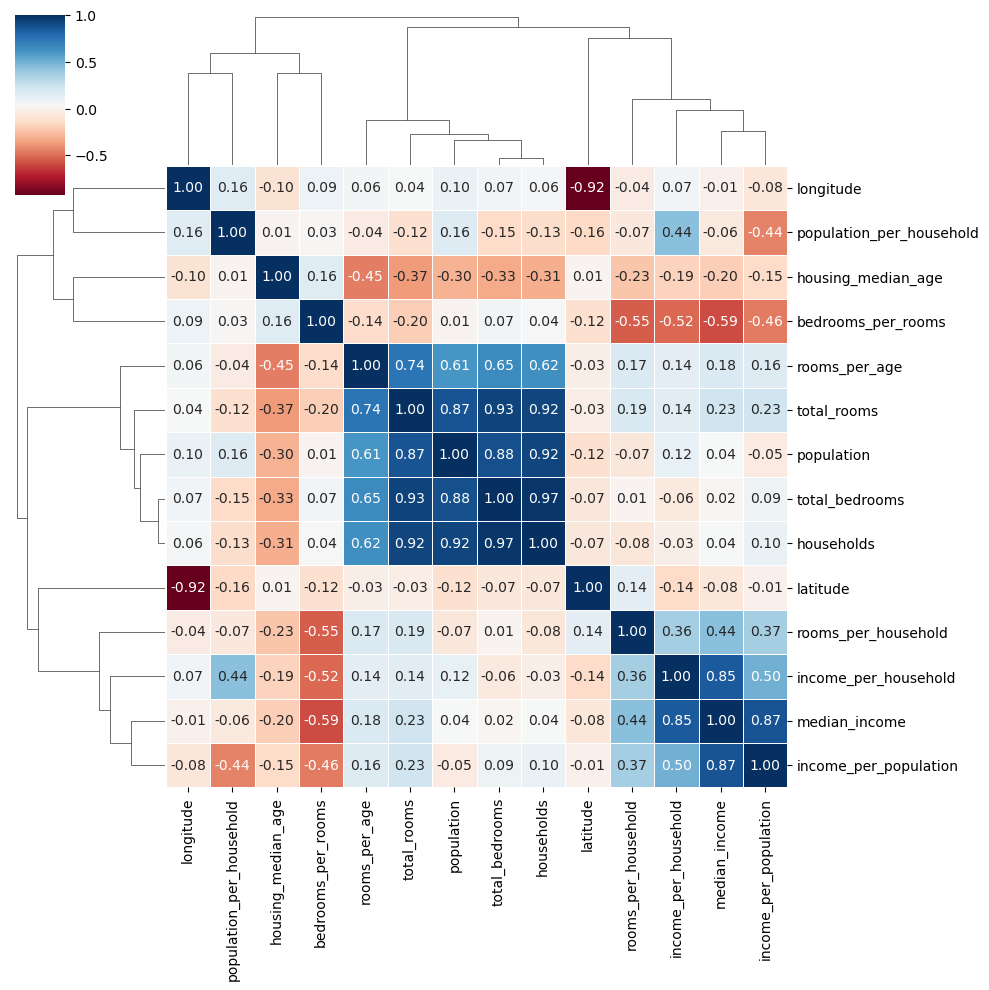

In [35]:
plt.figure(figsize=(10, 8))
sns.clustermap(corr_matrix_outliers_dropped.drop(index=['median_house_value'], columns=['median_house_value']), 
               annot=True, fmt='.2f', cmap='RdBu', lw=0.5);

## Create your own columntransformer that will add its own index to the data and then will keep the track of deleted rows, at the end it will merge category data onto a numerical data.

Now we can try to create a class that will be a part of the main preprocessing pipeline, that will handle the highly correlated groups in a 3 different ways, discussed earlier, as the last one is to just do nothing.

By default we will be treating two groups: 1 (total_rooms, population, total_bedrooms, households), 2 (income_per_household, median_income, income_per_population).

We can use scikit-learn PCA or implement it ourselves. We will build very simple PCA class for more control.

For the third option, we have to define what "capturing the effect of the group" really means.

In [73]:
class small_PCA(BaseEstimator, TransformerMixin):
    '''
    Finds principal components of centered (not standardized) data. It does not use SVD approach.
    The method finds weights of orthogonal projections of data points onto a subspace that is 
    spanned by the basis constructed of orthonormal eigenvectors with highest eigenvalues. 
    Eigenvectors and eigenvalues are obtained by eigendecomposition of covariance matrix. The size
    of the basis is specified by the value of n_components.
    
    Args:
        n_components (int) - rank of reduced data
        X (np.ndarray)     - (m, n) dataset
        
    Methods:
        fit(X)       - estimates the orthonormal eigenbasis for the subspace
        transform(X) - produces the weights of orthogonal projections
    '''
    
    def __init__(self, n_components=None):
        '''
        Params:
            n_components (int) - rank of reduced data
        '''
        
        # check if the number of components has the right type and is greater than 0
        assert(isinstance(n_components, int) and (n_components > 0)), f'n_components must be an integer greater than 0.'
        
        self.n_components = n_components
        
    def fit(self, X):
        '''
        The method finds eigendecomposition of centered data of form $Q \Lambda Q^{T}$. Then,
        n - n_components lowest eigenvalues and eigenvectors are dropped. The columns of resulting
        basis span the subspace in question. Also, the values of eigenvalues are stored as well
        as their ratio.
        
        Params:
            X (np.ndarray) - (m, n) dataset
        '''
        
        # check if number of components is lower than the number of columns of data
        assert(self.n_components <= X.shape[1]), f'n_components are greater than number of features. {self.n_components} > {X.shape[1]}'
        
        # calculate and eigendecompose the covariance matrix
        cov_matrix = np.cov((X - X.mean(axis=0)).T)
        s, Q = np.linalg.eig(cov_matrix)
        
        # get n_components with highest values of eigenvalues
        Q_r = Q[:, s.argsort()[-self.n_components:]]
        self.reduced_basis = Q_r[:, ::-1] # ---> this assures the resulting data is similar with sklearn's PCA
        self.explained_variance_ = s
        self.explained_variance_ratio_ = s / s.sum()
        return self
    
    def transform(self, X):
        '''
        Reduce the dataset by finding the weights of orthogonal projections on the subspace Col(Q_r).
        Since Q_r has orthonormal columns, the weights can be obtained from $(Q_{r}^{T}X^{T})^{T} = XQ_{r}$.
        
        Args:
            X (np.ndarray)   - (m, n) dataset
            
        Returns:
            X_r (np.ndarray) - (m, n_components) principal components
        '''
        # return mean 0 results (it is not necessary at all, but the results will be the same as with sklearn's PCA)
        return (X - X.mean(axis=0)) @ self.reduced_basis

i think it would be the best solution to drop both option, as it introduces unnecessary complexity to the code, and the simple solution is to use this two times, or make a simple function that takes a list and loops for groups, so.

In [37]:
class MulticollinearityHandler(BaseEstimator, TransformerMixin):
    
    def __init__(self, method, group, n_components=None):
        assert(method in ['drop', 'pca', 'gr_teatement']), f'Method {method} is invalid. Available methods: ["drop", "pca", "gr_treatement"].'
        assert(group in ['first', 'second', 'both']), f'Group {group} is invalid. Please, choose one of available: ["first", "second", "both"]. For more information consult documentation.'
        self.method = method
        self.group = group
        self.groups = dict(first = ['total_rooms', 'population', 'total_bedrooms', 'households'],
                           second = ['income_per_household', 'median_income', 'income_per_population'],
                           both = ['total_rooms', 'population', 'total_bedrooms', 'households'] +\
                                  ['income_per_household', 'median_income', 'income_per_population'])
        self.n_components = n_components
    
    def get_indexes_for_group(self, group):
        # create a matrix [feature_name index_number]
        tmp_holder = np.array([*col_idx_dict.items()])
        #get the indexes for given group
        _indexes = [
            tmp_holder[tmp_holder[:, 0] == col, 1].astype(int)[0] 
            for col in self.groups[group]
        ]
        return _indexes
    
    def get_the_least_corr_features_idx(self, X, group):
        # get the group indexes
        group_indexes = self.get_indexes_for_group(group)
        # mask
        X_indexed = X[:, group_indexes + [col_idx_dict['median_house_value']]]
        # calculate correlation with the target variable
        _correlation = np.corrcoef(X_indexed.T)[-1, :-1]
        # get the indexes of the least correlated features
        _low_corr_features_idx = np.array(group_indexes)[_correlation.argsort()[:-1]]
        return _low_corr_features_idx
    
    def fit(self, X, y=None):
        
        if (self.method == 'drop') and (self.group != 'both'):
            self.idx_to_drop = self.get_the_least_corr_features_idx(X, self.group)
        #else:
        #    self.idx_to_drop = np.append(self.get_the_least_corr_features_idx(X, 'first'),
        #                                 self.get_the_least_corr_features_idx(X, 'second'))
        
        if self.method == 'pca':
            assert(self.n_components is not None), f'Specify the number of components.'
            # get the group indexes
            self.idx_to_reduce = self.get_indexes_for_group(self.group)
            # pca should be done in transform
            
        if self.method == 'gr_treatement':
            pass
        
        return self
    
    def transform(self, X, y=None):
        
        if self.method == 'drop':
            return np.delete(X, self.idx_to_drop, axis=1)
        
        if (self.method == 'pca') and (self.group != 'both'):
            s_pca = small_PCA(n_components=self.n_components)
            X_reduced = s_pca.fit_transform(X[:, self.idx_to_reduce])
            X_concat = np.c_[np.delete(X, self.idx_to_reduce, axis=1),
                             X_reduced]
            return X_concat

In [77]:
class MulticollinearityHandler(BaseEstimator, TransformerMixin):
    '''
    This class tries to deal with multicollinearity problem implementing three different methods.
    1. Simply drop all but one feature. This method leaves the one feature that has the highest
       correlation with the target variable.
    2. Use small_PCA to reduce the dimention of the correlated features within a specified group.
    3. Uses method described by Min Tsao et al. (sorce at the end) It tries to find a vector of
       weights w that catches the overall effect of the group.
       
    The methods described above can be choosen by specifying the method argument, respectively:
    "drop"          - drops all but one feature within group
    "pca"           - uses small_PCA class
    "gr_treatement" - uses the method of M. Tsao
       
    Since two highly correlated groups were recognized, there is only option to choose one of the
    groups:
    "first"  - ['total_rooms', 'population', 'total_bedrooms', 'households']
    "second" - ['income_per_household', 'median_income', 'income_per_population']
    
    Args:
        method (str)       - method to choose when reducing the data
        group (str)        - one of ["first", "second"]
        n_components (int) - rank of reduced data when using 
        X (np.ndarray)     - (m, n) dataset
        
    Methods:
        get_indicies_for_group(group)
            finds column numbers of features given the specified group. 
            
        get_the_least_corr_features_group(X, gropu)
            finds the features that has the least correlation with the target variable
            
        fit(X)
            given the selected method it proceedes with finding the indexes that should be dropped
            
        transform(X)
            transforms the data using the indexes found in fit() method
            
    Sorce:
        Min Tsao "Group least squares regression for linear models with strongly correlated predictor
        variables". 
        DOI:      https://doi.org/10.1007/s10463-022-00841-7
        arXiv:    https://doi.org/10.48550/arXiv.1804.02499
        Accessed: 2/20/23
        
    '''    
    def __init__(self, method, group, n_components=None):
        '''
        Params:
            method (str)       - method to choose when reducing the data
            group (str)        - one of ["first", "second"]
            n_components (int) - rank of reduced data when using 
        '''
        assert(method in ['drop', 'pca', 'gr_teatement']), f'Method {method} is invalid. Available methods: ["drop", "pca", "gr_treatement"].'
        assert(group in ['first', 'second']), f'Group {group} is invalid. Please, choose one of available: ["first", "second"]. For more information consult documentation.'
        self.method = method
        self.group = group
        self.groups = dict(first = ['total_rooms', 'population', 'total_bedrooms', 'households'],
                           second = ['income_per_household', 'median_income', 'income_per_population'])
        self.n_components = n_components
    
    def get_indicies_for_group(self, group):
        '''
        Finds column numbers of features given the specified group. The method uses a globaly specified
        dictionary that specifies the column number given the feature name. The dictionary must be 
        specified beforehand. The main pipeline is responsible for creating this dictionary.
        
        Args:
            group (str) - one of ["first", "second"]
        
        Returns:
            _indicies (list) - list of indicies that specifies the pair feature - column number
        '''
        
        # create a matrix [feature_name index_number]
        tmp_holder = np.array([*col_idx_dict.items()])
        
        #get the indexes for given group
        _indicies = [
            tmp_holder[tmp_holder[:, 0] == col, 1].astype(int)[0] 
            for col in self.groups[group]
        ]
        
        return _indicies
    
    def get_the_least_corr_features_idx(self, X, group):
        '''
        Finds the features that has the least correlation with the target variable. The method uses a 
        globaly specified dictionary that specifies the column number given the feature name. The 
        dictionary must be specified beforehand. The main pipeline is responsible for creating this dictionary.
        
        Args:
            X (np.ndarray) - (m, n) dataset
            group (str)    - one of ["first", "second"]
            
        Returns:
            _low_corr_features_idx (np.ndarray) - array of column numbers for the least correlated with
                                                  the target variable features
        '''
        # get the group indexes
        group_indicies = self.get_indicies_for_group(group)
        # mask
        X_indexed = X[:, group_indicies + [col_idx_dict['median_house_value']]]
        # calculate correlation with the target variable
        _correlation = np.corrcoef(X_indexed.T)[-1, :-1]
        # get the indexes of the least correlated features
        _low_corr_features_idx = np.array(group_indicies)[_correlation.argsort()[:-1]]
        return _low_corr_features_idx
    
    def fit(self, X):
        
        if self.method == 'drop':
            self.idx_to_drop = self.get_the_least_corr_features_idx(X, self.group)
        
        if self.method == 'pca':
            assert(self.n_components is not None), f'Specify the number of components.'
            # get the group indexes
            self.idx_to_reduce = self.get_indicies_for_group(self.group)
            # pca should be done in transform
            
        if self.method == 'gr_treatement':
            # to be added, i have to first figure out the context of the article.
            pass
        
        return self
    
    def transform(self, X):
        
        if self.method == 'drop':
            return np.delete(X, self.idx_to_drop, axis=1)
        
        if self.method == 'pca':
            s_pca = small_PCA(n_components=self.n_components)
            X_reduced = s_pca.fit_transform(X[:, self.idx_to_reduce])
            X_concat = np.c_[np.delete(X, self.idx_to_reduce, axis=1),
                             X_reduced]
            return X_concat

In [78]:
a = MulticollinearityHandler(method='pca', group='first', n_components=1)
a.fit(tr_num.values)
a.transform(tr_num.values)[0, :]

array([  -120.5       ,     37.34      ,     16.        ,      3.4559    ,
       108000.        ,      5.68493151,     15.08602922,      0.79167584,
            0.18554217,      4.3652968 ,     77.8125    ,   1511.60970422])

In [40]:
a = MulticollinearityHandler(method='drop', group='both')
a.fit(tr_num_outliers_dropped.values)
a.idx_to_drop

AssertionError: Group both is invalid. Please, choose one of available: ["first", "second"]. For more information consult documentation.

In [ ]:
w = tr_num_outliers_dropped[['income_per_household', 'median_income', 'income_per_population', 'median_house_value']].corr()['median_house_value'][:-1].values

In [ ]:
w

In [ ]:
X = tr_num_outliers_dropped[['income_per_household', 'median_income', 'income_per_population']].values

In [ ]:
w_norm = w / np.linalg.norm(w, ord=1)

In [ ]:
X_new = X @ w_norm.reshape(-1, 1)

In [ ]:
y = tr_num_outliers_dropped['median_house_value'].values
np.corrcoef(np.c_[X_new, y].T)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=150, max_samples=0.9)
rf.fit(X, y)

In [ ]:
rf.score(X, y)

In [ ]:
w_rf = rf.feature_importances_
w_rf

In [ ]:
X_rf = X @ w_rf.reshape(-1, 1)

In [ ]:
np.corrcoef(np.c_[X_rf, y].T)

In [ ]:
from sklearn.linear_model import HuberRegressor

In [ ]:
hr = HuberRegressor(epsilon=3, alpha=0.0008)
hr.fit(X, y)
hr.score(X, y)

In [ ]:
w_hr = np.abs(hr.coef_)
w_hr = w_hr / np.linalg.norm(w_hr, ord=1)

In [ ]:
w_hr

In [ ]:
X_hr = X @ w_hr.reshape(-1, 1)
np.corrcoef(np.c_[X_hr, y].T)

In [ ]:
from sklearn.linear_model import RANSACRegressor, LinearRegression

In [ ]:
lin_rg = LinearRegression()
ran = RANSACRegressor(lin_rg, min_samples=1000, max_trials=1000)
ran.fit(X, y)
ran.score(X, y)

In [ ]:
w_ran = np.abs(ran.estimator_.coef_)
w_ran = w_ran / np.linalg.norm(w_ran, ord=1)
w_ran

In [ ]:
X_ran = X @ w_ran.reshape(-1, 1)
np.corrcoef(np.c_[X_ran, y].T)

In [ ]:
plt.hexbin(X_new.flatten(), y, cmap='turbo', mincnt=1)

In [ ]:
plt.hexbin(X_rf.flatten(), y, cmap='turbo', mincnt=1)

In [ ]:
plt.hexbin(X_hr.flatten(), y, cmap='turbo', mincnt=1)

In [ ]:
a = np.array([*col_idx_dict.items()])
[a[a[:, 0] == col, 1].astype(int)[0] for col in ['total_rooms', 'population', 'total_bedrooms', 'households']]

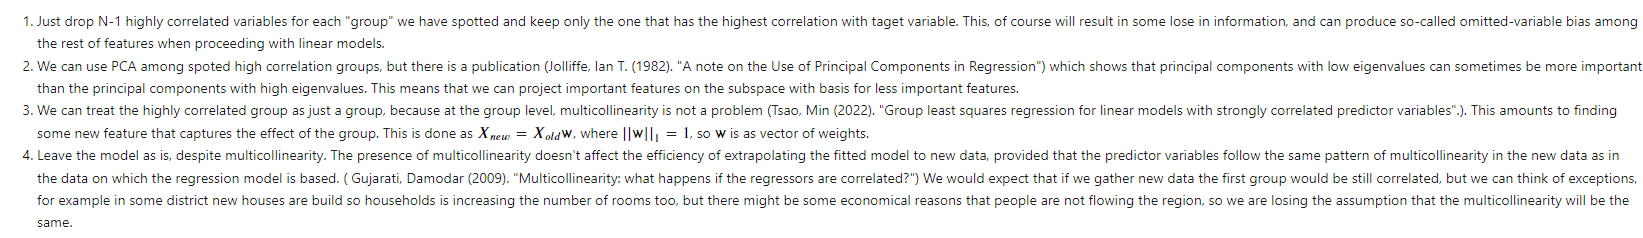

In [ ]:
sns.boxplot(x=tr_cat, y=tr_num['median_house_value'], palette='turbo', width=0.5)

'income_per_household', 'median_income', 'income_per_population'

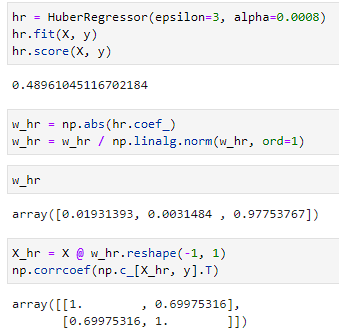

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
plt.hexbin(PCA(n_components=1).fit_transform(X).flatten(), y, cmap='turbo', mincnt=1)

In [ ]:
plt.hexbin(small_PCA(n_components=1).fit_transform(X).flatten(), y, cmap='turbo', mincnt=1)

In [ ]:
np.corrcoef(np.c_[small_PCA(n_components=1).fit_transform(X).flatten(), y].T)

In [ ]:
np.corrcoef(np.c_[PCA(n_components=1).fit_transform(X).flatten(), y].T)